# SeaweedFS Docker Compose Architecture Visualization

This notebook visualizes the SeaweedFS Docker Compose setup, showing the relationships between containers, networks, volumes, and how the components interact with each other.

## Overview

SeaweedFS is a simple and highly scalable distributed file system that offers:
- S3 API compatibility
- Fast data access
- Simple deployment
- Horizontal scalability

## 1. Import Required Libraries

In [6]:
!pip install networkx plotly


     |██████████▉                     | 3.3 MB 24.5 MB/s eta 0:00:01  Downloading plotly-6.3.0-py3-none-any.whl (9.8 MB)
     |████████████████████████████████| 9.8 MB 24.5 MB/s eta 0:00:01
     |████████████████████████████████| 9.8 MB 24.5 MB/s 
     |████████████████████████████████| 404 kB 94.1 MB/s eta 0:00:01
     |████████████████████████████████| 404 kB 94.1 MB/s eta 0:00:01


In [7]:
import yaml
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from IPython.display import HTML, display
import boto3
import json
from dotenv import load_dotenv

# Set up plotting
plt.style.use('ggplot')
%matplotlib inline

## 2. Parse Docker Compose File

First, let's parse the Docker Compose file to understand the structure of our setup.

In [8]:
# Function to read Docker Compose file
def read_docker_compose(filepath):
    with open(filepath, 'r') as file:
        compose_data = yaml.safe_load(file)
    return compose_data

# Path to Docker Compose file
compose_file_path = 'docker-compose.yml'

# Read Docker Compose file
compose_data = read_docker_compose(compose_file_path)

# Display basic info
print(f"Services defined: {list(compose_data['services'].keys())}")
print(f"Networks defined: {list(compose_data.get('networks', {}).keys())}")
print(f"Volumes defined: {list(compose_data.get('volumes', {}).keys())}")

Services defined: ['master', 'volume', 'filer']
Networks defined: ['external', 'internal']
Volumes defined: ['volume', 'filer']


## 3. Extract Container Details

Let's extract detailed information about each container in the SeaweedFS setup.

In [9]:
# Function to extract key container details
def extract_container_details(compose_data):
    containers = []
    
    for service_name, service_config in compose_data['services'].items():
        container = {
            'name': service_name,
            'image': service_config.get('image', 'N/A'),
            'ports': service_config.get('ports', []),
            'networks': service_config.get('networks', []),
            'depends_on': service_config.get('depends_on', {}),
            'volumes': service_config.get('volumes', []),
            'command': service_config.get('command', 'N/A'),
            'environment': service_config.get('environment', {})
        }
        containers.append(container)
    
    return containers

# Extract container details
containers = extract_container_details(compose_data)

# Display container details in a DataFrame
container_df = pd.DataFrame(containers)
display(container_df[['name', 'image', 'command']])

,name,image,command
0,master,chrislusf/seaweedfs,master -ip=master
1,volume,chrislusf/seaweedfs,volume -ip=volume -port=8080 -mserver=master:9...
2,filer,chrislusf/seaweedfs,"filer -master=""master:9333"" -ip=filer -port=88..."


## 4. Create Container Relationship Graph

Now, let's create a graph representing the relationships between containers.

In [10]:
# Create a directed graph
G = nx.DiGraph()

# Add service nodes
for service_name in compose_data['services']:
    G.add_node(service_name, type='service')

# Add network nodes
if 'networks' in compose_data:
    for network_name in compose_data['networks']:
        G.add_node(f"network:{network_name}", type='network')
        
# Add volume nodes
if 'volumes' in compose_data:
    for volume_name in compose_data['volumes']:
        G.add_node(f"volume:{volume_name}", type='volume')

# Connect services to networks
for service_name, service_config in compose_data['services'].items():
    if 'networks' in service_config:
        for network in service_config['networks']:
            G.add_edge(service_name, f"network:{network}")
    
    # Connect services to volumes
    if 'volumes' in service_config:
        for volume in service_config['volumes']:
            if ':' in volume and not volume.startswith('/'):
                volume_name = volume.split(':')[0]
                if volume_name in compose_data.get('volumes', {}):
                    G.add_edge(service_name, f"volume:{volume_name}")
    
    # Connect service dependencies
    if 'depends_on' in service_config:
        depends_on = service_config['depends_on']
        if isinstance(depends_on, dict):
            for dependency in depends_on:
                G.add_edge(service_name, dependency)
        elif isinstance(depends_on, list):
            for dependency in depends_on:
                G.add_edge(service_name, dependency)

## 5. Visualize Container Relationships

Let's create a visual representation of the container relationships.

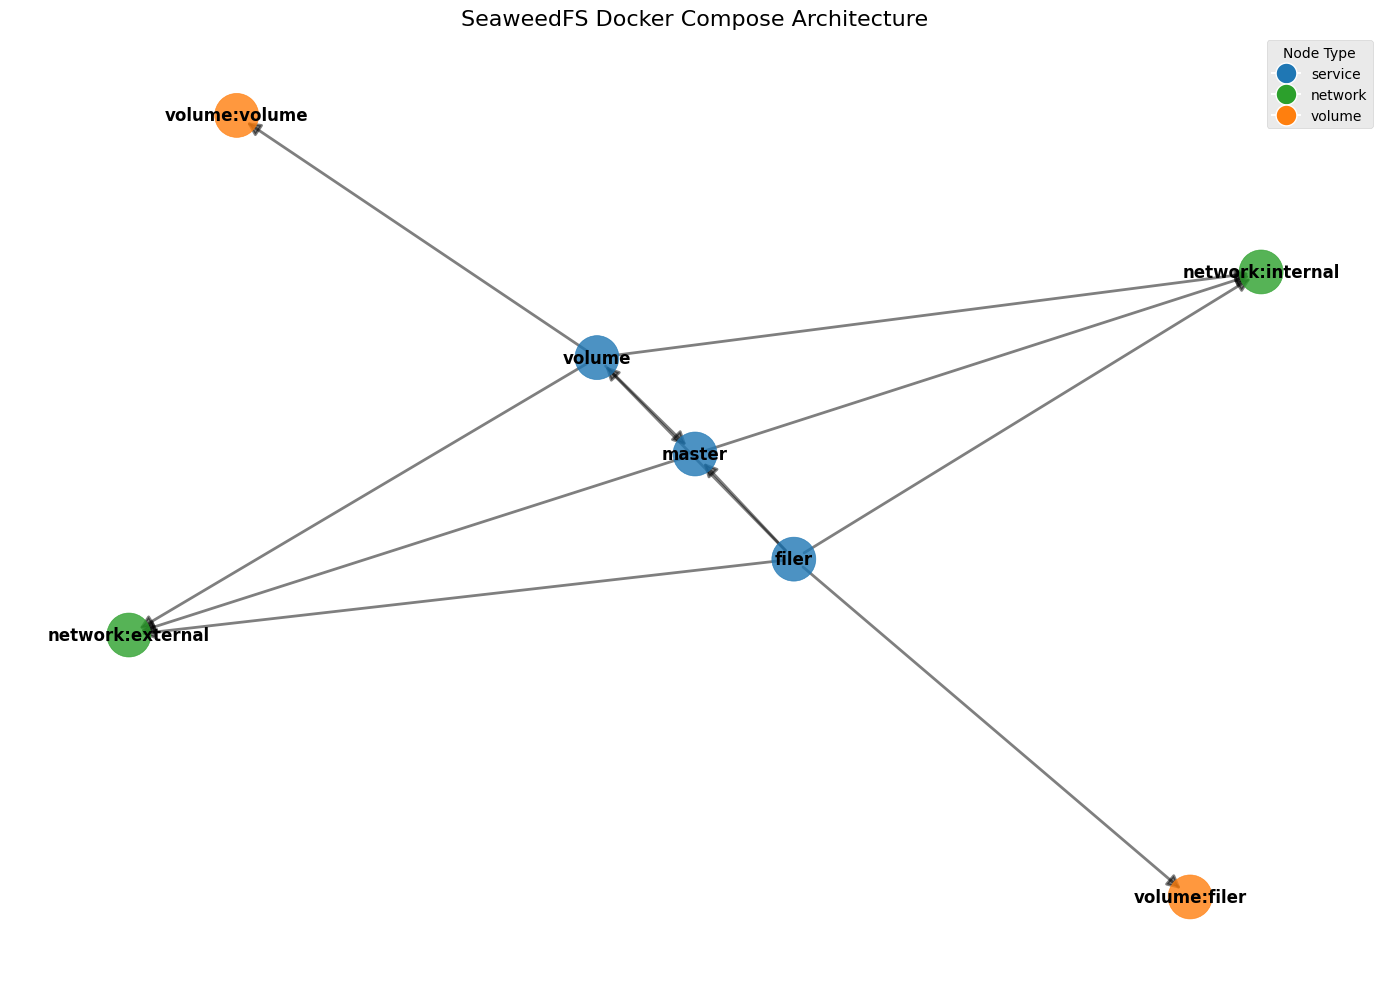

In [11]:
# Define colors for different node types
node_colors = {
    'service': '#1f77b4',  # blue
    'network': '#2ca02c',  # green
    'volume': '#ff7f0e'    # orange
}

# Create a dictionary mapping node names to colors
node_color_map = [node_colors[G.nodes[node]['type']] for node in G.nodes()]

# Create a figure
plt.figure(figsize=(14, 10))

# Define layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes with colors based on type
nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=1000, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, arrowsize=20)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=label)
    for label, color in node_colors.items()
]
plt.legend(handles=legend_elements, title='Node Type', loc='upper right')

# Remove axes
plt.axis('off')
plt.title('SeaweedFS Docker Compose Architecture', fontsize=16)
plt.tight_layout()
plt.show()

## 6. Interactive Visualization with Plotly

Let's create an interactive visualization to better explore the relationships.

In [12]:
# Create an interactive visualization using Plotly
def create_interactive_graph(G):
    # Calculate node positions with networkx
    pos = nx.spring_layout(G, seed=42)
    
    # Create edge traces
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    # Create node traces (separate trace for each node type)
    node_traces = {}
    for node_type, color in node_colors.items():
        node_traces[node_type] = go.Scatter(
            x=[], y=[],
            mode='markers+text',
            hoverinfo='text',
            text=[],
            marker=dict(
                color=color,
                size=30,
                line=dict(width=2, color='#000'))
        )
    
    # Add nodes to their respective traces
    for node in G.nodes():
        x, y = pos[node]
        node_type = G.nodes[node]['type']
        node_name = node
        node_traces[node_type]['x'] += tuple([x])
        node_traces[node_type]['y'] += tuple([y])
        node_traces[node_type]['text'] += tuple([node_name])
    
    # Create figure
    fig = go.Figure(
        data=[edge_trace] + list(node_traces.values()),
        layout=go.Layout(
            title='Interactive SeaweedFS Docker Compose Architecture',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=0, l=0, r=0, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
    )
    
    return fig

# Create and display the interactive graph
fig = create_interactive_graph(G)
fig.show()

## 7. Architecture Diagram

Below is a static architectural diagram of the SeaweedFS setup:

In [20]:
architecture_diagram = """
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                            Client (Browser/API Client)                                                 │
│                                                                                                        │
└────────────────────────────────────────┬───────────────────────────────────────────────────────────────┘
                                         │
                                         ▼
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                                   Public Internet                                                      │
│                                                                                                        │
└───────────┬────────────────────────────┬───────────────────────────────────┬───────────────────────────┘
            │                            │                                   │
            │                            │                                   │
            ▼                            ▼                                   ▼
┌─────────────────────────┐  ┌─────────────────────────┐  ┌──────────────────────────────────────────────┐
│ seaweed-master.${DOMAIN}│  │ seaweed-volume.${DOMAIN}│  │    seaweed.${DOMAIN}    seaweed-s3.${DOMAIN} │
└───────────┬─────────────┘  └───────────┬─────────────┘  └──────────────────┬───────────────────────────┘
            │                            │                                   │
            │                            │                                   │
            ▼                            ▼                                   ▼
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                             Traefik Reverse Proxy                                                      │
│                               (TLS termination)                                                        │
│                                                                                                        │
└───────────┬────────────────────────────┬───────────────────────────────────┬───────────────────────────┘
            │                            │                                   │
            │                            │                                   │
            ▼                            ▼                                   ▼
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                                External Network                                                        │
│                                                                                                        │
└────────────────────────────────────────┬───────────────────────────────────────────────────────────────┘
                                         │
                                         │
                                         ▼
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                                                   Internal Network                                     │
│                                                                                                        │
└───────────┬────────────────────────────┬───────────────────────────────────┬───────────────────────────┘
            │                            │                                   │
            │                            │                                   │
            ▼                            ▼                                   ▼
┌─────────────────────┐      ┌───────────────────────┐       ┌───────────────────────────────────────────┐
│                     │      │                       │       │                                           │
│    Master Server    │      │    Volume Server      │       │  Filer Server                             │
│    (master:9333)    │◄---─►│    (volume:8080)      │◄─----►│  (filer:8888, S3:8333)                    │
│                     │      │                       │       │                                           │
└───────────┬─────────┘      └───────────┬───────────┘       └───────────────┬───────────────────────────┘
            │                            │                                   │
            │                            │                                   │
            ▼                            ▼                                   ▼
┌─────────────────────┐      ┌───────────────────────┐       ┌───────────────────────────────────────────┐
│    No Persistent    │      │     volume:/data      │       │           filer:/data                     │
│       Storage       │      │     (Volumes Data)    │       │        (Metadata Storage)                 │
└─────────────────────┘      └───────────────────────┘       └───────────────────────────────────────────┘
"""

print(architecture_diagram)


┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                            Client (Browser/API Client)                                                 │
│                                                                                                        │
└────────────────────────────────────────┬───────────────────────────────────────────────────────────────┘
                                         │
                                         ▼
┌────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                                                                                        │
│                                   Public Internet                                                      │
│                                                        

## 8. Component Details

Let's examine each component in more detail:

In [14]:
# Create detailed component descriptions
component_details = {
    'master': {
        'name': 'Master Server',
        'container': 'demo-master-1',
        'primary_port': 9333,
        'role': 'Coordination and management',
        'description': 'Manages volume servers, assigns volume IDs, and maintains cluster topology.',
        'persistence': 'None (stateless coordination)',
        'key_endpoints': [
            '/cluster/status - Shows cluster health',
            '/vol/lookup - Find volume location',
            '/vol/grow - Add new volumes'
        ]
    },
    'volume': {
        'name': 'Volume Server',
        'container': 'demo-volume-1',
        'primary_port': 8080,
        'role': 'Data storage',
        'description': 'Stores and serves file data chunks (needles) organized into volumes.',
        'persistence': 'volume:/data Docker volume',
        'key_endpoints': [
            '/status - Server health',
            '/stats/counter - Statistics',
            '/{volume_id}/{needle_id} - Access file chunks'
        ]
    },
    'filer': {
        'name': 'Filer Server',
        'container': 'demo-filer-1',
        'primary_ports': '8888 (Filer API), 8333 (S3 API)',
        'role': 'File management and S3 API',
        'description': 'Provides a directory hierarchy, manages file metadata, and offers S3 compatibility.',
        'persistence': 'filer:/data Docker volume',
        'key_endpoints': [
            '/ - Web UI and directory browsing',
            '/buckets/* - S3 bucket operations',
            '/{path} - File operations'
        ]
    }
}

# Function to format component details as HTML
def format_component_details(component):
    details = component_details[component]
    html = f"""
    <div style="background-color:#f5f5f5; border:1px solid #ddd; border-radius:5px; padding:15px; margin-bottom:20px;">
        <h3 style="color:#2c3e50;">{details['name']} ({component})</h3>
        <p><strong>Container:</strong> {details['container']}</p>
        <p><strong>Primary Port(s):</strong> {details['primary_port'] if 'primary_port' in details else details['primary_ports']}</p>
        <p><strong>Role:</strong> {details['role']}</p>
        <p><strong>Description:</strong> {details['description']}</p>
        <p><strong>Persistence:</strong> {details['persistence']}</p>
        <p><strong>Key Endpoints:</strong></p>
        <ul>
    """
    
    for endpoint in details['key_endpoints']:
        html += f"<li>{endpoint}</li>"
    
    html += """
        </ul>
    </div>
    """
    
    return html

# Display component details
for component in component_details.keys():
    display(HTML(format_component_details(component)))

## 9. Interacting with S3 API

Let's see how to interact with the SeaweedFS S3 API using Python's boto3 library:

In [15]:
# Load environment variables (AWS credentials)
load_dotenv()

# Function to create an S3 client
def create_s3_client():
    """
    Create an S3 client configured to connect to SeaweedFS S3 API
    """
    # Load AWS credentials from environment variables
    aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
    aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
    
    # Create S3 client
    s3_client = boto3.client(
        's3',
        endpoint_url='http://localhost:8333',
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name='us-east-1',  # Default region
        verify=False  # Skip SSL verification for local development
    )
    
    return s3_client

# Format and display S3 bucket listing
def format_table(data, title=None):
    """
    Format data as a styled HTML table
    """
    from IPython.display import HTML
    
    # Convert to DataFrame for easy formatting
    if isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = pd.DataFrame(data)
    
    try:
        # Try to use DataFrame styling (requires jinja2)
        styled_df = df.style
        if title:
            styled_df = styled_df.set_caption(title)
        styled_df = styled_df.set_properties(**{
            'text-align': 'left',
            'border': '1px solid #ddd',
            'padding': '8px',
            'background-color': '#f5f5f5'
        })
        return styled_df
    except AttributeError:
        # Fallback to basic HTML if styling is not available
        html = df.to_html(index=False)
        if title:
            html = f"<h4>{title}</h4>" + html
        return HTML(html)

In [16]:
# List S3 buckets
def list_s3_buckets_api():
    """
    List all S3 buckets using the S3 API
    """
    try:
        s3_client = create_s3_client()
        response = s3_client.list_buckets()
        buckets = [{
            'Name': bucket['Name'],
            'CreationDate': bucket['CreationDate'].strftime('%Y-%m-%d %H:%M:%S%z')
        } for bucket in response['Buckets']]
        
        print(f"S3 Buckets: {buckets}")
        return format_table(buckets, title="S3 Buckets")
    except Exception as e:
        print(f"Error listing buckets: {e}")
        return None

# Run the bucket listing function
list_s3_buckets_api()

Error listing buckets: Could not connect to the endpoint URL: "http://localhost:8333/"


## 10. Key SeaweedFS Operations and Workflow

Let's examine the workflow of how data is stored and retrieved in SeaweedFS:

In [17]:
workflow = """
1. Write Operation Flow:
   ┌────────┐     1. Request to store file    ┌─────────────┐
   │ Client │────────────────────────────────>│ Filer (8888)│
   └────────┘                                 └──────┬──────┘
       ▲                                             │
       │                                             │ 2. Request volume ID
       │                                             ▼
       │                                      ┌─────────────┐
       │                                      │Master (9333)│
       │                                      └──────┬──────┘
       │                                             │
       │                                             │ 3. Assign volume ID
       │                                             ▼
       │                                      ┌─────────────┐
       │       6. Return file ID and URL      │Filer (8888) │
       │<─────────────────────────────────────┤             │
       │                                      └──────┬──────┘
       │                                             │
       │                                             │ 4. Write file chunks
       │                                             ▼
       │                                      ┌─────────────┐
       │                                      │Volume (8080)│
       └──────────────────────────────────────┤             │
          5. File stored successfully         └─────────────┘

2. Read Operation Flow:
   ┌────────┐     1. Request to read file     ┌─────────────┐
   │ Client │────────────────────────────────>│ Filer (8888)│
   └────────┘                                 └──────┬──────┘
       ▲                                             │
       │                                             │ 2. Look up file metadata
       │                                             ▼
       │                                      ┌─────────────┐
       │      3. Get volume and file ID       │Filer (8888) │
       │<─────────────────────────────────────┤ (metadata)  │
       │                                      └─────────────┘
       │
       │      4. Request file chunks          ┌─────────────┐
       └─────────────────────────────────────>│Volume (8080)│
                                              └──────┬──────┘
       ┌────────┐                                    │
       │ Client │<───────────────────────────────────┘
       └────────┘     5. Return file data

3. S3 API Operation Flow:
   ┌────────┐     1. S3 API request           ┌─────────────┐
   │ Client │────────────────────────────────>│ Filer (8333)│
   └────────┘                                 └──────┬──────┘
       ▲                                             │
       │                                             │ 2. Internal processing
       │                                             ▼
       │                                      ┌─────────────┐
       │      4. S3 API response              │Filer (8888) │
       │<─────────────────────────────────────┤             │
       │                                      └──────┬──────┘
                                                     │
                                                     │ 3. Storage operations
                                                     ▼
                                              ┌─────────────┐
                                              │Volume (8080)│
                                              └─────────────┘
"""

print(workflow)


1. Write Operation Flow:
   ┌────────┐     1. Request to store file    ┌─────────────┐
   │ Client │────────────────────────────────>│ Filer (8888)│
   └────────┘                                 └──────┬──────┘
       ▲                                             │
       │                                             │ 2. Request volume ID
       │                                             ▼
       │                                      ┌─────────────┐
       │                                      │Master (9333)│
       │                                      └──────┬──────┘
       │                                             │
       │                                             │ 3. Assign volume ID
       │                                             ▼
       │                                      ┌─────────────┐
       │       6. Return file ID and URL      │Filer (8888) │
       │<─────────────────────────────────────┤             │
       │                                     

## 11. SeaweedFS Scaling Options

SeaweedFS is designed to be highly scalable. Let's explore how this setup can be scaled:

In [18]:
scaling_options = [
    {
        "Component": "Master",
        "Scaling Strategy": "Multiple masters in a Raft cluster for high availability",
        "Configuration": "Add multiple master instances with peer settings",
        "Benefits": "Fault tolerance, no single point of failure"
    },
    {
        "Component": "Volume",
        "Scaling Strategy": "Horizontal scaling with multiple volume servers",
        "Configuration": "Add more volume servers, configure replication",
        "Benefits": "Increased storage capacity, read/write throughput"
    },
    {
        "Component": "Filer",
        "Scaling Strategy": "Multiple filers with shared metadata",
        "Configuration": "Use shared database (MySQL, Redis, etc.) for metadata",
        "Benefits": "Load balancing, increased client connection capacity"
    }
]

# Display scaling options
format_table(scaling_options, title="SeaweedFS Scaling Options")

,Component,Scaling Strategy,Configuration,Benefits
0,Master,Multiple masters in a Raft cluster for high availability,Add multiple master instances with peer settings,"Fault tolerance, no single point of failure"
1,Volume,Horizontal scaling with multiple volume servers,"Add more volume servers, configure replication","Increased storage capacity, read/write throughput"
2,Filer,Multiple filers with shared metadata,"Use shared database (MySQL, Redis, etc.) for metadata","Load balancing, increased client connection capacity"


## 12. Summary

SeaweedFS provides a simple yet powerful distributed file system with:

1. **Master Server**: Coordinates cluster operations and volume assignment
2. **Volume Server**: Stores and serves actual file data
3. **Filer Server**: Provides file/directory abstraction and S3 API compatibility

This setup can be used for various applications:

- Object storage with S3 API compatibility
- Image and video storage
- Backup and archival
- Content delivery
- Big data applications

The system can be scaled horizontally by adding more volume servers, creating a master cluster for high availability, and deploying multiple filers for increased throughput.